In [1]:
import os
import wandb

import utilities as ut
import matplotlib.pyplot as plt

from huggingface_hub import HfApi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import Callback

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_dataset = {
    "train": "./dataset/splited_dataset/train",
    "test": "./dataset/splited_dataset/test",
}
hyperparameters = {
    "augmentation": True,
    "image_size": (128, 128),
    "batch_size": 32,
    "epochs": 20,
    "learning_rate": None,
    "optimizer": "adam",
    "loss": "sparse_categorical_crossentropy",
    "metrics": ["accuracy"],
    "model_structure": {
        "conv": 2,
        "pool": 2,
        "batchnorm": 2,
        "dropout": 1,
        "dense": 2},
}
optimizer_map = {
    "adam": Adam(),
    "sgd": SGD(),
    "rmsprop": RMSprop(),
    "adamax": Adamax(),
}
labels = os.listdir(path_dataset["train"])
commit_message = "update model (add dropout layer)"

In [3]:
path_imgs_train = ut.get_imgs_path(path_dataset["train"], labels)
path_imgs_test = ut.get_imgs_path(path_dataset["test"], labels)

In [4]:
trainset = ut.create_dataset(path_imgs_train, hyperparameters["image_size"], hyperparameters["batch_size"])
testset = ut.create_dataset(path_imgs_test, hyperparameters["image_size"], hyperparameters["batch_size"])

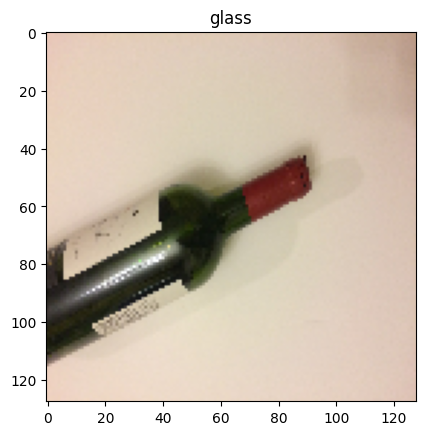

In [5]:
for img, label in trainset.take(1):
    plt.imshow(img[0].numpy())
    plt.title(labels[label[0]])
    plt.show()

In [6]:
wandb.init(project="trash-classification",
            name=
            config=hyperparameters)
config = wandb.config

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bugi-sulistiyo (bugi-sulistiyo-universitas-mulawarman). Use `wandb login --relogin` to force relogin


In [7]:
model = Sequential([
    Conv2D(16, (3, 3), activation="relu", input_shape=(config.image_size[0], config.image_size[1], 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu", input_shape=(config.image_size[0], config.image_size[1], 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(path_imgs_train.label.unique()), activation="softmax")
])

In [8]:
model.compile(
    optimizer=optimizer_map[config.optimizer],
    loss=config.loss,
    metrics=config.metrics
)
class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [ ]:
model.fit(
    trainset,
    validation_data=testset,
    epochs=config.epochs,
    callbacks=[CustomWandbCallback()]
)

Epoch 1/20


64/64 [==============================] - 52s 387ms/step - loss: 3.2031 - accuracy: 0.3508 - val_loss: 2.4297 - val_accuracy: 0.1897
Epoch 2/20
64/64 [==============================] - 54s 366ms/step - loss: 1.7696 - accuracy: 0.4399 - val_loss: 6.4618 - val_accuracy: 0.2036
Epoch 3/20
64/64 [==============================] - 61s 394ms/step - loss: 1.4720 - accuracy: 0.4923 - val_loss: 8.1969 - val_accuracy: 0.2134
Epoch 4/20
64/64 [==============================] - 61s 316ms/step - loss: 1.2576 - accuracy: 0.5136 - val_loss: 6.8055 - val_accuracy: 0.2826
Epoch 5/20
64/64 [==============================] - 50s 373ms/step - loss: 1.2325 - accuracy: 0.5591 - val_loss: 4.0150 - val_accuracy: 0.3024
Epoch 6/20
64/64 [==============================] - 48s 363ms/step - loss: 1.0118 - accuracy: 0.6022 - val_loss: 2.3635 - val_accuracy: 0.4091
Epoch 7/20
64/64 [==============================] - 45s 337ms/step - loss: 0.9388 - accuracy: 0.6333 - val_loss: 2.1628 - val_accuracy: 0.45

In [19]:
model.save("model/vanila_cnn.h5")
model.save("model/vanila_cnn")
wandb.log_artifact("model/vanila_cnn.h5", type="model")
wandb.finish()

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Artifact run-awzau5hm-vanila_cnn.h5>

In [23]:
api = HfApi()
repo = api.create_repo("trash-classification", repo_type="model", exist_ok=True)
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj="model/vanila_cnn.h5",
    path_in_repo="model/vanila_cnn.h5",
    repo_type=repo.repo_type,
    commit_message=f".h5 file - {commit_message}"
)
api.upload_folder(
    repo_id=repo.repo_id,
    folder_path="model/vanila_cnn",
    path_in_repo="model/vanila_cnn",
    repo_type=repo.repo_type,
    commit_message=f"weights folder - {commit_message}"
)